In [1]:
import numpy as np
import gym
import seaborn as sns
import pandas as pd
sns.set()

***
# Q-learning

***
### Value Function
Recall the definition of the **value function** $V(s_t)$:

$$
V(s_t) = \mathbb{E} \left[ G_t \vert s_t \right]
$$

In an MDP, our expected discounted return $G_t$ depends on the trajectories $\tau$ that we generate. Whereas in a Markov process or Markov reward process this depends only on the underlying state dynamics, in an MDP, trajectories also depend on the actions that we choose. Since these actions are determined by our **policy** $\pi$, we write the following:

$$
V^\pi (s_t) = \mathbb{E}_\pi \left[ G_t \vert s_t \right]
$$

that is, given that we are currently in state $s_t$, what value should we expect our discounted return $G_t$ to be, given that we generate trajectories according to our policy $\pi$?

***
### Action-Value function
We can define an analogous definition for the **action-value function**, which extends the notion of the value function to account for choosing a *specific action* $a_t$ in a state $s_t$, rather than just choosing the one suggested by the policy:

$$
Q^\pi (s_t, a_t) = \mathbb{E}_\pi \left[ G_t \vert s_t, a_t \right]
$$

that is, given that we are currently in state $s_t$, taking action $a_t$, what value should we expect our discounted return $G_t$ to be? We can see the relationship between $V^\pi (s_t)$ and $Q^\pi (s_t, a_t)$:

$$
V^\pi (s_t) = \mathbb{E}_{a_t \sim \pi} \left[ Q^\pi (s_t, a_t) \vert s_t \right]
$$

where $a_t \sim \pi$ means 'over actions $a_t$ selected according to a probability distribution $\pi$'.

We also have a Bellman equation for the state-value function:
$$
Q^\pi (s_t, a_t) = \mathbb{E}_\pi \left[ r_t + \gamma Q^\pi (s_{t+1}, a_{t+1}) \vert s_t, a_t \right]
$$

***
### $Q$-learning
$Q$-learning is an algorithm analogous to the TD(0) algorithm we've described before. In TD(0), we have a table $V$ containing predictions for $V^\pi (s_t)$ for each state $s_t$, updating our predictions as follows:

$$
V (s_t) \gets V (s_t) + \alpha \left( r_t + \gamma V (s_{t+1}) - V (s_t) \right)
$$

In $Q$-learning, we have a similar learning rule, except that our table now contains values for any state-action pair $(s_t, a_t)$.

$$
Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha \left( r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right)
$$

The advantage of $Q$-learning is that we have an estimate, for each action, of the expected discounted return we will get from taking that action. Recall the reward hypothesis:

> Every action of a rational agent can be thought of as seeking to maximize some cumulative scalar reward signal.

Consider being in some state $s_t$, and for each action $a_t$ we compute $Q(s_t, a_t)$. These values are our guesses for the discounted return we will get as a result of choosing each action. If we choose the action that maximizes $Q(s_t, a_t)$, then our agent is maximizing the discounted return. This defines a **greedy policy**

$$
\pi(a_t \vert s_t) = \begin{cases} 1, & a_t = \arg \max_{a_t} Q(s_t, a_t) \\ 0, & \text{otherwise} \end{cases}
$$

Knowing this, we can estimate the $Q$ value for the next state-action pair $(s_{t+1}, a_{t+1})$ by assuming the agent chooses the action that maximizes that $Q$ value. This gives us the following update rule:

$$
Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_{a_{t+1}} \left( Q(s_{t+1}, a_{t+1}) \right) - Q(s_t, a_t) \right)
$$

***
### Modified Bellman Equation and Terminal States
Recall that some environments are **episodic**. This means that there must be some states $s_T$ where, regardless of what action is chosen, the next state is always $s_T$ and the reward is always $0$. The `gym` library defines an environment api with a `step` function that returns $s_{t+1}, r_t, d_t,$ info given an action $a_t$. Here, $d_t$ is a boolean flag denoting whether or not $s_{t+1}$ is terminal.

By the definition of $Q(s_t, a_t)$, we can see that $r_t + \gamma Q(s_{t+1}, a_{t+1})$ is an unbiased estimate for $Q(s_t, a_t)$. This is what gives us the Bellman equation update rule. If we know that a state is terminal, then we have an even better estimate: if $s_t$ is terminal, then $G_t = r_t$, and our update rule is just

$$
Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha \left( r_t - Q(s_t, a_t) \right)
$$

If we interpret the truthiness of $d_t$ as an integer (i.e., $d_t = 1$ if `True` and $0$ if `False`), then we can define a modified update rule that takes terminal states into account:

$$
Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha \left( r_t + (1-d_t)\gamma \max_{a_{t+1}} \left( Q(s_{t+1}, a_{t+1}) \right) - Q(s_t, a_t) \right)
$$

***
### Exploration-Exploitation

Our agent can quickly become stuck in a suboptimal policy by always choosing the same action in the same state. Recall that we use the greedy policy to choose actions. If we choose a certain action in a certain state, it's because that action has the maximal $Q$ value associated with it. If we always follow the greedy policy, we will generally tend to continue to choose this action since we don't get the opportunity to explore (and thus update our predictions for) the other actions. This problem is known as the **exploration-exploitation tradeoff**: should we try to learn more about the $Q$ function by exploring (and thus finding a better policy) or should we exploit what we know about the environment to try to maximize the returns that we know about?

### $\epsilon$-greedy policies

The simplest approach to solving the exploration-exploitation tradeoff is to randomly choose an action $a_t \sim \mathcal{A}$ rather than from the policy $a_t \sim \pi$. We choose a random action with a probability $\epsilon$. At the beginning of training, the agent should not follow its policy, since its estimates for $Q(s_t, a_t)$ are poor. Instead, the agent should focus on gathering as much data as possible to improve its guesses, and should do this by exploring. This means that initially, $\epsilon$ should be high (close to 1). Over time, as our predictions for $Q(s_t, a_t)$ improve, we can trust our prediction and thus our greedy policy more, and thus $\epsilon$ should be low (close to 0).

We define $\epsilon_i$ to be the initial value for $\epsilon$ and $\epsilon_f$ to be the final value. We decay $\epsilon$ using either linear or exponential decay. Linear decay means we subtract a constant from $\epsilon$ at every time step, and exponential decay means we multiply $\epsilon$ by some decay factor less than 1. Here we use linear decay.

In [2]:
class Agent:
    def __init__(self, num_states, num_actions, 
                 epsilon_i=1.0, 
                 epsilon_f=0.0, 
                 n_epsilon=0.1, 
                 alpha=0.5, 
                 gamma = 0.95):
        
        """
        num_states: the number of states in the discrete state space
        num_actions: the number of actions in the discrete action space
        epsilon_i: the initial value for epsilon
        epsilon_f: the final value for epsilon
        n_epsilon: a float between 0 and 1 determining at which point
        during training epsilon should have decayed from epsilon_i to
        epsilon_f
        alpha: the learning rate
        gamma: the decay rate
        """
        
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.epsilon = epsilon_i
        self.n_epsilon = n_epsilon
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.Q = np.zeros((num_states, num_actions))

    def decay_epsilon(self, n):
        """
        Decays the agent's exploration rate according to n, which is a
        float between 0 and 1 describing how far along training is, 
        with 0 meaning 'just started' and 1 meaning 'done'.
        """
        self.epsilon = max(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))
    
    def act(self, s_t):
        """
        Epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        return np.argmax(self.Q[s_t])
    
    def update(self, s_t, a_t, r_t, s_t_next, d_t):
        """
        Uses the q-learning update rule to update the agent's predictions
        for Q(s_t, a_t).
        """
        Q_next = np.max(self.Q[s_t_next])
        self.Q[s_t, a_t] = self.Q[s_t, a_t] + \
        self.alpha*(r_t + (1-d_t)*self.gamma*Q_next - \
        self.Q[s_t, a_t])

In [3]:
def plot(data, window=100):
    """
    Given a pandas dataframe 'data', plots a rolling mean of the data
    using a window size of 'window'.
    """
    sns.lineplot(
        data=data.rolling(window=window).mean()[window-1::window]
    )

In [4]:
def train(env_name,
         T=100000, 
          alpha=0.8, 
          gamma=0.95, 
          epsilon_i = 1.0, 
          epsilon_f = 0.0, 
          n_epsilon = 0.1):
    env = gym.make(env_name)
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    agent = Agent(num_states, num_actions, 
                  alpha=alpha, 
                  gamma=gamma, 
                  epsilon_i=epsilon_i, 
                  epsilon_f=epsilon_f, 
                  n_epsilon = n_epsilon)

    rewards = []
    episode_rewards = 0
    
    s_t = env.reset()
    
    for t in range(T):
        a_t = agent.act(s_t)
        s_t_next, r_t, d_t, info = env.step(a_t)
        agent.update(s_t, a_t, r_t, s_t_next, d_t)
        agent.decay_epsilon(t/T)
        s_t = s_t_next
        episode_rewards += r_t
        
        if d_t:
            rewards.append(episode_rewards)
            episode_rewards = 0
            s_t = env.reset()
            
    plot(pd.DataFrame(rewards))
    return agent

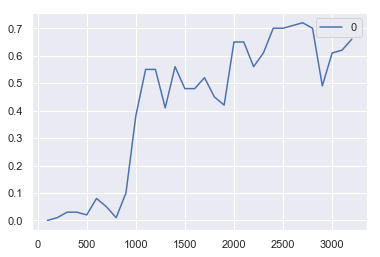

In [7]:
train("FrozenLake-v0", T=100000)